['225.0_69.0_0.0_2024-02-15T11 57 48.123Z.jpg', 'Tray_1_225.69.0.jpeg', 'Tray_2_628.69.0.jpeg', 'Tray_3_1018.69.0.jpeg', 'Tray_4_1415.69.0.jpeg', 'Tray_5_1815.69.0.jpeg', 'Tray_6_2204.69.0.jpeg', 'Tray_6_2204.69.0_cal.jpeg', 'Tray_7_2594.69.0.jpeg']
../data/farmbot_tray/225.0_69.0_0.0_2024-02-15T11 57 48.123Z.jpg
Tray center coordinates are valid.
Tray center coordinates:  x: 225.0 y: 69.0


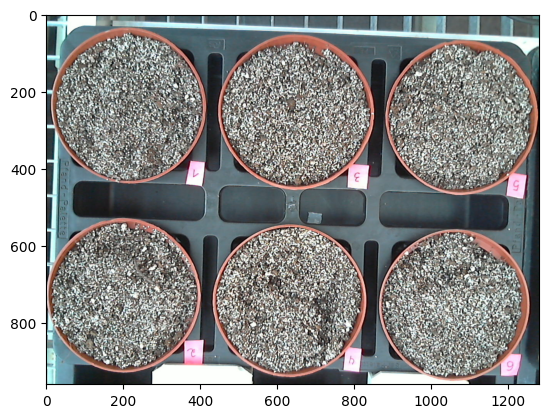

In [6]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import numpy as np
from plantcv import plantcv as pcv
import time
import math
import random

# Define constants
IMAGE_DIR = '../data/farmbot_tray/'
IMAGE_EXT = ('.jpg', '.jpeg', '.png')
IMAGE_WIDTH = 1280 # in pixels
IMAGE_HEIGHT = 960 # in pixels
TRAY_CENTER_X = 0.0 # in mm, this will be updated later
TRAY_CENTER_Y = 0.0 # in mm, this will be updated later
TRAY_CENTER_Z = 0.0 # in mm, this will be updated later
DIA_OF_POT = 60 # in mm
DIA_OF_ROI = 50 # in mm DIAMETER OF REGION OF INTEREST (ROI), should be less than DIA_OF_POT
LENGTH_TRAY_A = 150 # in mm
LENGTH_TRAY_B = 135 # in mm
ROTATION_ANGLE = -2 # in degrees
RATIO_MM2PIX = 3.2 # in pixels per mm
OFF_SET_CAM_X = 0 # in mm
OFF_SET_CAM_Y = 5 # in mm

def rotate(x, y, angle):
    x_new = int(x * np.cos(np.radians(-angle)))
    y_new = int(y * np.sin(np.radians(-angle)))
    return x_new, y_new

def de_ref(x, y, angle, x0, y0):
    a = np.tan(np.radians(angle))*y
    x_new = x0 + int((x-a)*np.cos(np.radians(angle)))
    y_new = y0 - int(y/np.cos(np.radians(angle)) + (x-a)*np.sin(np.radians(angle)))
    return x_new, y_new

def plt_img_show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Get the list of files in the directory
file_list = os.listdir(IMAGE_DIR)

# Filter out non-image files
image_files = [file for file in file_list if file.endswith(IMAGE_EXT)]

# Sort the image files alphabetically
image_files.sort()

# Read the first image file
if image_files:
    first_image_path = os.path.join(IMAGE_DIR, image_files[0])
    first_image = cv2.imread(first_image_path)
    # Do further processing with the first image
else:
    print("No image files found in the directory.")

# Print the list of image files
print(image_files)
print(first_image_path)

# Update the tray center coordinates
filenameparts = image_files[0].split('_')
TRAY_CENTER_X = float(filenameparts[0])
TRAY_CENTER_Y = float(filenameparts[1])
TRAY_CENTER_Z = float(filenameparts[2])
# check the tray center coordinates, x,y should be positive, z should be 0.0
if TRAY_CENTER_X > 0 and TRAY_CENTER_Y > 0 and TRAY_CENTER_Z == 0.0:
    print("Tray center coordinates are valid.")
    print("Tray center coordinates: ", "x:", TRAY_CENTER_X, "y:", TRAY_CENTER_Y)
else:
    print("Tray center coordinates are not valid.")

# print the first image using matplotlib
plt_img_show(first_image)

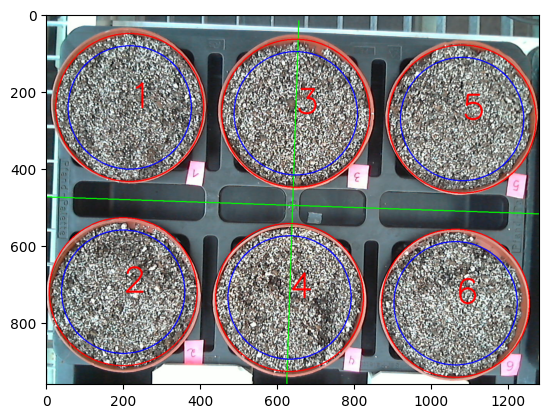

In [7]:
# Copy the first image to a control image
control_image = first_image.copy()

# Calculate the middle point of the image
middle_x = int(IMAGE_WIDTH / 2 + OFF_SET_CAM_X*RATIO_MM2PIX)
middle_y = int(IMAGE_HEIGHT / 2 + OFF_SET_CAM_Y*RATIO_MM2PIX)

# Draw the horizontal and vertical refference lines on the image
    # Calculate the start and end point of the horizental line based on the angle
line_length = int(IMAGE_WIDTH/2) # Adjust the length of the line as needed
start_x_ref = -int(line_length)
start_y_ref = int(0)
end_x_ref = int(line_length)
end_y_ref = int(0)
    # Draw the line on the image
cv2.line(control_image, de_ref(start_x_ref, start_y_ref,ROTATION_ANGLE,middle_x,middle_y),
         de_ref(end_x_ref, end_y_ref,ROTATION_ANGLE,middle_x,middle_y), (0, 255, 0), 2)

    # Calculate the start and end point of the vertical line based on the angle
line_length = int(IMAGE_HEIGHT/2) # Adjust the length of the line as needed
start_x_ref = int(0)
start_y_ref = int(line_length)
end_x_ref = int(0)
end_y_ref = -int(line_length)
    # Draw the line on the image
cv2.line(control_image, de_ref(start_x_ref, start_y_ref,ROTATION_ANGLE,middle_x,middle_y),
         de_ref(end_x_ref, end_y_ref,ROTATION_ANGLE,middle_x,middle_y), (0, 255, 0), 2)


# Calculate the center of the 6 pots
center_of_pots = []
    # caleculate the center of the 1. pot
        #center of the 1. pot on the reference coordinate system
center_x_1_ref = 0 - LENGTH_TRAY_B * RATIO_MM2PIX
center_y_1_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_1, center_y_1 = de_ref(center_x_1_ref, center_y_1_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_1, center_y_1))
cv2.circle(img=control_image, center=(center_x_1, center_y_1), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_1, center_y_1), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '1', (center_x_1, center_y_1), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 2. pot
        #center of the 2. pot on the reference coordinate system
center_x_2_ref = 0 - LENGTH_TRAY_B * RATIO_MM2PIX
center_y_2_ref = -(LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_2, center_y_2 = de_ref(center_x_2_ref, center_y_2_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_2, center_y_2))
cv2.circle(img=control_image, center=(center_x_2, center_y_2), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_2, center_y_2), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '2', (center_x_2, center_y_2), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 3. pot
        #center of the 3. pot on the reference coordinate system
center_x_3_ref = 0
center_y_3_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_3, center_y_3 = de_ref(center_x_3_ref, center_y_3_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_3, center_y_3))
cv2.circle(img=control_image, center=(center_x_3, center_y_3), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_3, center_y_3), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '3', (center_x_3, center_y_3), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 4. pot
        #center of the 4. pot on the reference coordinate system
center_x_4_ref = 0
center_y_4_ref = -(LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_4, center_y_4 = de_ref(center_x_4_ref, center_y_4_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_4, center_y_4))
cv2.circle(img=control_image, center=(center_x_4, center_y_4), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_4, center_y_4), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '4', (center_x_4, center_y_4), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 5. pot
        #center of the 5. pot on the reference coordinate system
center_x_5_ref = 0 + LENGTH_TRAY_B * RATIO_MM2PIX
center_y_5_ref = (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_5, center_y_5 = de_ref(center_x_5_ref, center_y_5_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_5, center_y_5))
cv2.circle(img=control_image, center=(center_x_5, center_y_5), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_5, center_y_5), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '5', (center_x_5, center_y_5), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)
    # caleculate the center of the 6. pot
        #center of the 6. pot on the reference coordinate system
center_x_6_ref = 0 + LENGTH_TRAY_B * RATIO_MM2PIX
center_y_6_ref = - (LENGTH_TRAY_A * RATIO_MM2PIX)/2
center_x_6, center_y_6 = de_ref(center_x_6_ref, center_y_6_ref, ROTATION_ANGLE, middle_x, middle_y)
center_of_pots.append((center_x_6, center_y_6))
cv2.circle(img=control_image, center=(center_x_6, center_y_6), radius=int(DIA_OF_POT*RATIO_MM2PIX), color=(0, 0, 255), thickness=2)
cv2.circle(img=control_image, center=(center_x_6, center_y_6), radius=int(DIA_OF_ROI*RATIO_MM2PIX), color=(255, 0, 0), thickness=2)
cv2.putText(control_image, '6', (center_x_6, center_y_6), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)

# Display the image with the line
plt_img_show(control_image)

217 242
200 720
648 257
632 735
1080 272
1063 750


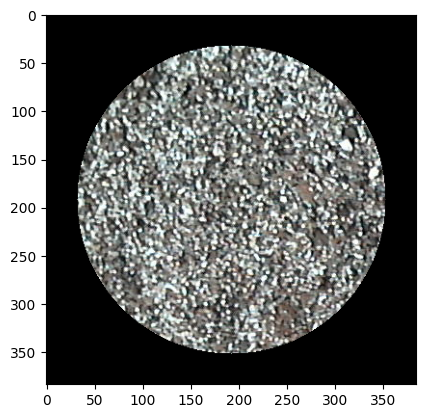

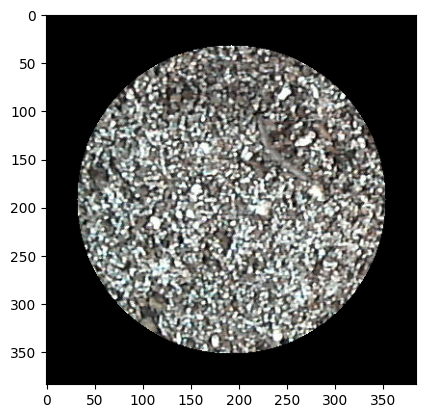

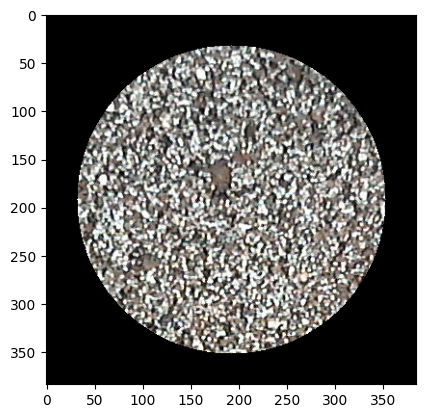

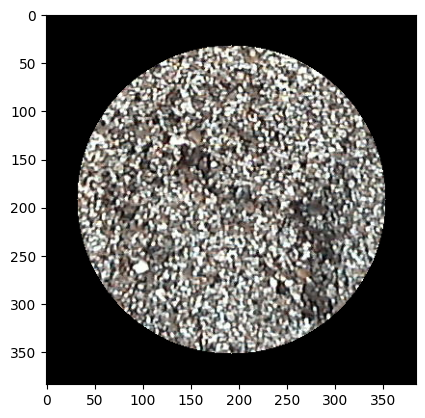

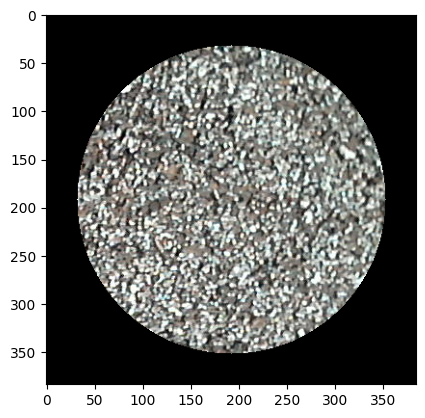

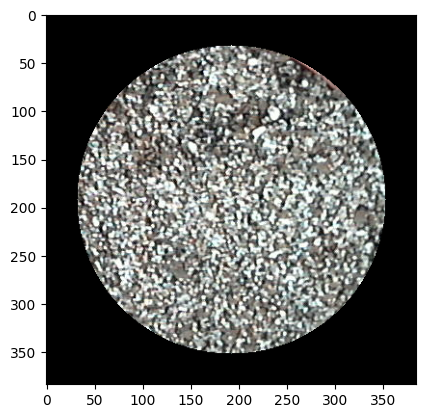

In [8]:
def pick_roi_area(center_x, center_y, image):
    # Calculate the coordinates of the top-left and bottom-right corners of the ROI
    roi_x1 = int(center_x - DIA_OF_POT * RATIO_MM2PIX)
    roi_y1 = int(center_y - DIA_OF_POT * RATIO_MM2PIX)
    roi_x2 = int(center_x + DIA_OF_POT * RATIO_MM2PIX)
    roi_y2 = int(center_y + DIA_OF_POT * RATIO_MM2PIX)

    # Crop the ROI from the image
    roi = image[roi_y1:roi_y2, roi_x1:roi_x2]

    # Set pixels outside of the ROI circle to black
    mask = np.zeros_like(roi)
    radius = int(DIA_OF_ROI * RATIO_MM2PIX)
    center = (roi.shape[1] // 2, roi.shape[0] // 2)  # Set center as the middle of the ROI
    cv2.circle(mask, center, radius, (255, 255, 255), -1)
    roi = cv2.bitwise_and(roi, mask)

    # Return the ROI
    return roi

# Calculate the area of the ROI for each pot
roi_areas = []
for center_x, center_y in center_of_pots:
    print(center_x, center_y)
    roi_area = pick_roi_area(center_x, center_y, first_image)
    roi_areas.append(roi_area)

# Display the areas of the ROIs using plt_img_show
for img in roi_areas:
    plt_img_show(img)

############################# START #############################
processing image:
	 total 2 region(s) found!


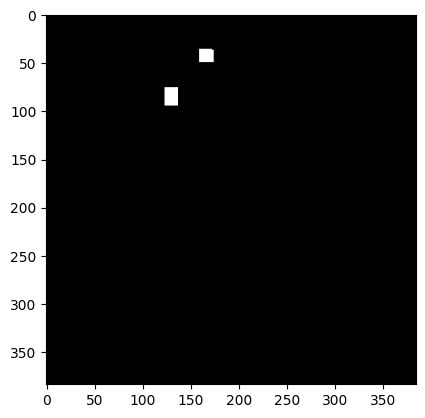

	 prossible watering point: (203, 189)
	 prossible watering point: (163, 200)
	 prossible watering point: (294, 122)
	 prossible watering point: (210, 170)
	 prossible watering point: (227, 167)
	 prossible watering point: (95, 285)
	 prossible watering point: (294, 309)
	 prossible watering point: (208, 218)
	 prossible watering point: (138, 205)
	 prossible watering point: (162, 145)
	 prossible watering point: (148, 172)
	 prossible watering point: (194, 211)
	 prossible watering point: (118, 223)
	 prossible watering point: (199, 204)
	 prossible watering point: (75, 121)
	 prossible watering point: (185, 171)
	 prossible watering point: (82, 96)
	 prossible watering point: (238, 47)
	 prossible watering point: (150, 166)
	 prossible watering point: (152, 176)
	 prossible watering point: (227, 192)
	 prossible watering point: (218, 259)
	 prossible watering point: (121, 136)
	 prossible watering point: (200, 155)
	 prossible watering point: (324, 163)
	 prossible watering point: (1

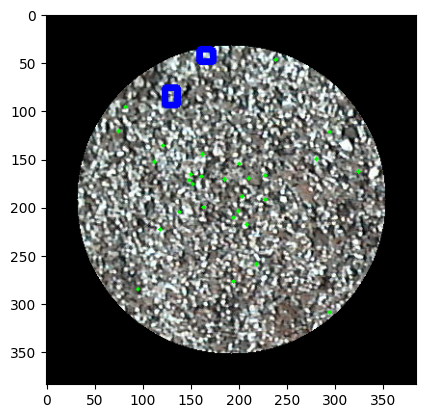

	 Execution time: 0.3 seconds
############################# END #############################




[(203, 189),
 (163, 200),
 (294, 122),
 (210, 170),
 (227, 167),
 (95, 285),
 (294, 309),
 (208, 218),
 (138, 205),
 (162, 145),
 (148, 172),
 (194, 211),
 (118, 223),
 (199, 204),
 (75, 121),
 (185, 171),
 (82, 96),
 (238, 47),
 (150, 166),
 (152, 176),
 (227, 192),
 (218, 259),
 (121, 136),
 (200, 155),
 (324, 163),
 (112, 153),
 (194, 277),
 (280, 150),
 (161, 168)]

In [14]:
#run all the test images at ones

def calculate_watering_points(img):
    pcv.params.debug="none"
    # Define the pot center and radius
    pot_x = int(img.shape[1] / 2)
    pot_y = int(img.shape[0] / 2)
    roi_radius = int(DIA_OF_ROI * RATIO_MM2PIX)
    # Set a timer for the execution time
    start_time = time.time()
    print('############################# START #############################')
    print('processing image:')
    # mask in H channel (this is a way to write in opencv, but we will use plantcv for this task)
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_H = img_HSV[:, :, 0] #all rows, all columns, first channel (Hue)
    img_H_thresh = cv2.inRange(img_H, 20, 40)
    # mask in A channel
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_A = img_LAB[:, :, 1] #all rows, all columns, second channel (A)
    img_A_hist_EQU = cv2.equalizeHist(img_A)
    _, img_A_thresh = cv2.threshold(img_A_hist_EQU, 31, 255, cv2.THRESH_BINARY)
    img_A_thresh = cv2.bitwise_not(img_A_thresh)
    # mask in V channel
    img_V = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 2]
    _, img_V_thresh_up = cv2.threshold(img_V, 250, 255, cv2.THRESH_BINARY_INV)
    _, img_V_thresh_down = cv2.threshold(img_V, 50, 255, cv2.THRESH_BINARY)
    img_V_thresh = cv2.bitwise_and(img_V_thresh_up, img_V_thresh_down)
    # combine H A V masks
    img_H_thresh_erode = cv2.erode(img_H_thresh, kernel=np.ones((5, 5), np.uint8), iterations=1)
    img_A_thresh_erode = cv2.erode(img_A_thresh, kernel=np.ones((5, 5), np.uint8), iterations=1)
    img_thresh = cv2.bitwise_or(img_A_thresh_erode, img_H_thresh_erode)
    img_thresh = cv2.bitwise_and(img_thresh, img_V_thresh)
    # closing method to the mask
    mask_dilated = cv2.dilate(img_thresh, kernel=np.ones((5, 5), np.uint8), iterations=2)
    mask_erode = cv2.erode(mask_dilated, kernel=np.ones((5, 5), np.uint8), iterations=3)
    mask_dilated = cv2.dilate(mask_erode, kernel=np.ones((5, 5), np.uint8), iterations=3)
    mask = mask_dilated

    # labeled the regions on the mask image
    labeled_mask, num_mask = pcv.create_labels(mask=mask)
    #pcv.plot_image(labeled_mask)
    print('{}'.format('\t'),'total', num_mask, 'region(s) found!')

    # just keep the first 10 biggst region on the mask
    count = 0
    region_info={}
    for region_id in range(1,num_mask+1,1):
        mask_region_cnt = cv2.inRange(labeled_mask,region_id,region_id)
        count = cv2.countNonZero(mask_region_cnt)
        region_info[region_id]= (region_id, count)
    list_of_region = list(region_info.values())
    sorted_data = sorted(list_of_region, key=lambda x: x[1], reverse=True)
    sorted_data_cop = sorted_data[:10]

    mask_cop = np.zeros(np.shape(mask),dtype=np.uint8)
    for region_id in sorted_data_cop:
        id = (int)(region_id[0])
        mask_cop+=cv2.inRange(labeled_mask,id,id)

    pcv.plot_image(mask_cop)


    # calculation the center of mass of the region
    # this will locate the plant
    contours, hierarchy = cv2.findContours(mask_cop,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
##    cnt = contours[0]
##    M = cv.moments(cnt)
##    cx = int(M['m10']/M['m00'])
##    cy = int(M['m01']/M['m00'])
##    print('{}'.format('\t'),'location of the plant(x,y):',cx,cy)
    mask_RGB=cv2.cvtColor(mask_cop,cv2.COLOR_GRAY2BGR)
    
    # let us define the watering point.
    num_watering_points = 4*7 # 4 time a day and 7 days a week
    # create watering point
    #angel = 30 # must be 15, 30, 45, 60, 90
    # the previous mask will be enlarged, so that there will be a safty zone, that we will not water the leaves
    mask_with_saftyzone = pcv.dilate(gray_img = mask_cop, ksize = 15, i = 3)
    watering_points_list = []
    count = 0
    while (count<=num_watering_points):
        angel = random.randint(0,360)
        rel_radius = random.random()
        x_watering_point = (int)(math.cos(angel/180*math.pi)*(roi_radius)*rel_radius+pot_x)
        y_watering_point = (int)(math.sin(angel/180*math.pi)*(roi_radius)*rel_radius+pot_y)
        if mask_with_saftyzone[y_watering_point, x_watering_point] != 255:
            watering_points_list.append((x_watering_point, y_watering_point))
            count+=1
        #watering_point_list.append((x_watering_point, y_watering_point))
            
    # lets draw everything on image
    img_out = img.copy()
    for i in watering_points_list:
        cv2.circle(img_out,i,2,(0,255,0),-1) # -1 means fill the circle
        print('{}'.format('\t'),'prossible watering point:',i)
    cv2.drawContours(img_out, contours, contourIdx=-1, color=(255,0,0), thickness=5)
    plt_img_show(img_out)
    
    
    end_time = time.time()
    print('{}'.format('\t'),'Execution time:', round(end_time - start_time, 2), 'seconds')
    print('############################# END #############################')
    print('{}'.format('\n'))
    #endfor
    return watering_points_list

calculate_watering_points(roi_areas[0])